In [41]:
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

sys.path.append(str(PROJECT_ROOT))

# Define path to the dataset folder
RAW_DATASET = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'


In [11]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET / filename)

df_tt = load_data('Turbine_telemetry.csv')
df_rd = load_data('Residential_demand.csv')
df_wd = load_data('kirkwall_weather.csv')

print(f"turbine telemetry shape: {df_tt.shape}")
print(f"residential demand shape: {df_rd.shape}")
print(f"weather data shape: {df_wd.shape}")




turbine telemetry shape: (1069636, 4)
residential demand shape: (17568, 3)
weather data shape: (16584, 9)


In [12]:
df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])

# Cleaning Turbine Telemetry Data

## Removing Data Points Where Wind Speed Is Fast Enough But No Power

In [13]:
# Find the minimum wind speed for power production
v_min = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed

print(f"minimum wind speed for power production: {v_min:.2f} m/s")

# Select only rows with Setpoint_kw == 900
df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[((df_tt.Wind_ms >= v_min) & (df_tt.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df_tt.dropna(inplace=True)

# Convert timestamp to datetime
df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])

# Clip the power to the setpoint 900 kW
df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

minimum wind speed for power production: 5.00 m/s
turbine telemetry data shape: (931575, 4)


,Timestamp,Power_kw,Setpoint_kw,Wind_ms
0,2015-05-28 00:00:23,80.0,900.0,4.9
1,2015-05-28 00:01:23,78.0,900.0,5.4
2,2015-05-28 00:02:23,52.0,900.0,4.9
3,2015-05-28 00:03:23,57.0,900.0,4.6
4,2015-05-28 00:04:23,54.0,900.0,4.6


In [14]:
df_tt_timeindex = df_tt.copy()

# Set the timestamp as index 
df_tt_timeindex['Timestamp'] = pd.to_datetime(df_tt_timeindex['Timestamp'])

df_tt_timeindex = df_tt_timeindex.set_index('Timestamp')

# Resample the data to 30-minute intervals
df_tt_resampled = df_tt_timeindex.resample('30min').mean()

# Select the data for the year 2017
df_tt_resampled_2017 = df_tt_resampled[
    (df_tt_resampled.index >= '2017-01-01') &
    (df_tt_resampled.index < '2018-01-02')
]


## Clean Resampled

In [15]:
df_tt_resampled['Month'] = df_tt_resampled.index.to_period('M')
df_tt_resampled['Month_int'] = df_tt_resampled['Month'].dt.month
df_tt_resampled['Year_int'] = df_tt_resampled.index.to_period('Y').year

df_tt_resampled.head()

,Power_kw,Setpoint_kw,Wind_ms,Month,Month_int,Year_int
Timestamp,,,,,,
2015-05-28 00:00:00,103.000000,900.0,5.533333,2015-05,5,2015
2015-05-28 00:30:00,204.000000,900.0,7.040000,2015-05,5,2015
2015-05-28 01:00:00,285.600000,900.0,7.876667,2015-05,5,2015
2015-05-28 01:30:00,457.266667,900.0,9.166667,2015-05,5,2015
2015-05-28 02:00:00,890.133333,900.0,12.973333,2015-05,5,2015


## Clean Original Timeseries

In [16]:
df_tt['Month'] = df_tt['Timestamp'].dt.to_period('M')
df_tt['Month_int'] = df_tt['Month'].dt.month
df_tt['Year_int'] = df_tt['Timestamp'].dt.year

df_tt.head()

,Timestamp,Power_kw,Setpoint_kw,Wind_ms,Month,Month_int,Year_int
0,2015-05-28 00:00:23,80.0,900.0,4.9,2015-05,5,2015
1,2015-05-28 00:01:23,78.0,900.0,5.4,2015-05,5,2015
2,2015-05-28 00:02:23,52.0,900.0,4.9,2015-05,5,2015
3,2015-05-28 00:03:23,57.0,900.0,4.6,2015-05,5,2015
4,2015-05-28 00:04:23,54.0,900.0,4.6,2015-05,5,2015


# Scraped Weather Data Cleaning

In [17]:

df_wd = load_data('kirkwall_weather.csv')
# Cleaning weather data
df_wd = df_wd.rename(columns={'Time': 'Timestamp'})
# Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

# Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

# aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

df_wd['Wind Speed (m/s)'] = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce').fillna(0.0)


print(f"Weather scrape columns: {df_wd.columns}")
df_wd.head()

Weather scrape columns: Index(['Timestamp', 'Icon', 'Temperature (F)', 'Description',
       'Wind Speed (m/s)', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)',
       'Visibility (mi)'],
      dtype='object')


,Timestamp,Icon,Temperature (F),Description,Wind Speed (m/s),Wind Direction,Humidity (%),Pressure (Hg),Visibility (mi)
0,2017-01-01 00:30:00,Passing clouds.,41,Passing clouds.,10.28,Wind blowing from 340° North-northwest to Sout...,81.0,30.04,NaN
1,2017-01-01 01:00:00,Quite cool.,43,Quite cool.,9.39,Wind blowing from 330° North-northwest to Sout...,81.0,30.04,NaN
2,2017-01-01 01:30:00,Passing clouds.,41,Passing clouds.,9.83,Wind blowing from 340° North-northwest to Sout...,87.0,30.04,NaN
3,2017-01-01 02:00:00,Passing clouds.,39,Passing clouds.,7.15,Wind blowing from 330° North-northwest to Sout...,87.0,30.07,5.0
4,2017-01-01 02:30:00,Passing clouds.,41,Passing clouds.,8.94,Wind blowing from 330° North-northwest to Sout...,76.0,30.07,NaN


## Join TT with Scraped Data

In [18]:
df_tt_resampled_2017 = df_tt_resampled_2017.reset_index()

# inner join resample 2017 turbine telemetry data with weather data  
df_tt_wd = pd.merge(
    df_wd[['Timestamp', 'Wind Speed (m/s)']],
    df_tt_resampled_2017[['Timestamp', 'Wind_ms', 'Power_kw']],
    how='inner',
    on='Timestamp'
)

# Rename columns for clarity
df_tt_wd = df_tt_wd.rename(columns={
    'Wind Speed (m/s)': 'Wind_speed_scraped',
    'Wind_ms': 'Wind_speed_baseline',
    'Power_kw': 'Power_baseline'
})

# Ensure Timestamp is a datetime
df_tt_wd['Timestamp'] = pd.to_datetime(df_tt_wd['Timestamp'])

# Create a 'Month' column for grouping
df_tt_wd['Month'] = df_tt_wd['Timestamp'].dt.to_period('M')
df_tt_wd['Month_int'] = df_tt_wd['Month'].dt.month


# Show result
df_tt_wd.head()


,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,Month_int
0,2017-01-01 00:30:00,10.28,16.106667,893.266667,2017-01,1
1,2017-01-01 01:00:00,9.39,16.380000,897.633333,2017-01,1
2,2017-01-01 01:30:00,9.83,17.083333,899.966667,2017-01,1
3,2017-01-01 02:00:00,7.15,16.800000,900.000000,2017-01,1
4,2017-01-01 02:30:00,8.94,18.021739,899.956522,2017-01,1


# Scrape and Baseline Analysis

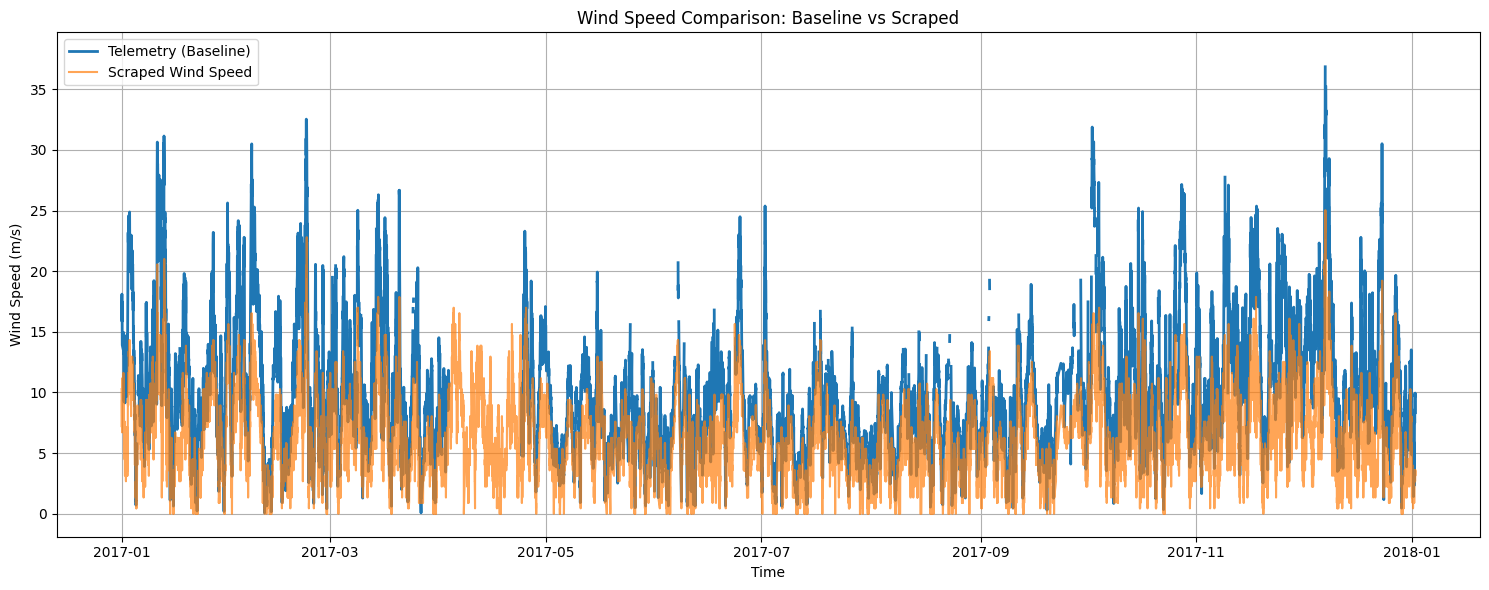

In [19]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Scraped')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Scraped-Baseline

In [20]:
# Calculation Correlation Between Wind Speed and Wind Speed Baseline
correlation = df_tt_wd['Wind_speed_scraped'].corr(df_tt_wd['Wind_speed_baseline'])
print("Correlation:", correlation)


Correlation: 0.8423381870134377


## Scaling with Monthly Percentage Differences

In [21]:
# Calculate monthly means
monthly_means = df_tt_wd.groupby('Month')[['Wind_speed_scraped', 'Wind_speed_baseline']].mean()

# Calculate correction factors
monthly_means['correction_factor'] = monthly_means['Wind_speed_baseline'] / monthly_means['Wind_speed_scraped']

# Join the correction factor back to the main dataframe
df_tt_wd = df_tt_wd.merge(monthly_means['correction_factor'], on='Month', how='left')

# Apply the correction
df_tt_wd['Wind_speed_monthly_scaled'] = df_tt_wd['Wind_speed_scraped'] * df_tt_wd['correction_factor']

monthly_means.head()


,Wind_speed_scraped,Wind_speed_baseline,correction_factor
Month,,,
2017-01,7.024976,11.909933,1.695370
2017-02,6.836293,11.803518,1.726596
2017-03,6.335610,10.563270,1.667285
2017-04,7.347837,10.880955,1.480838
2017-05,5.313900,7.740323,1.456618


In [22]:
# New Dataframe with the correction factor and scaled wind speed
df_tt_wd.head()

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,Month_int,correction_factor,Wind_speed_monthly_scaled
0,2017-01-01 00:30:00,10.28,16.106667,893.266667,2017-01,1,1.69537,17.428404
1,2017-01-01 01:00:00,9.39,16.380000,897.633333,2017-01,1,1.69537,15.919524
2,2017-01-01 01:30:00,9.83,17.083333,899.966667,2017-01,1,1.69537,16.665487
3,2017-01-01 02:00:00,7.15,16.800000,900.000000,2017-01,1,1.69537,12.121896
4,2017-01-01 02:30:00,8.94,18.021739,899.956522,2017-01,1,1.69537,15.156608


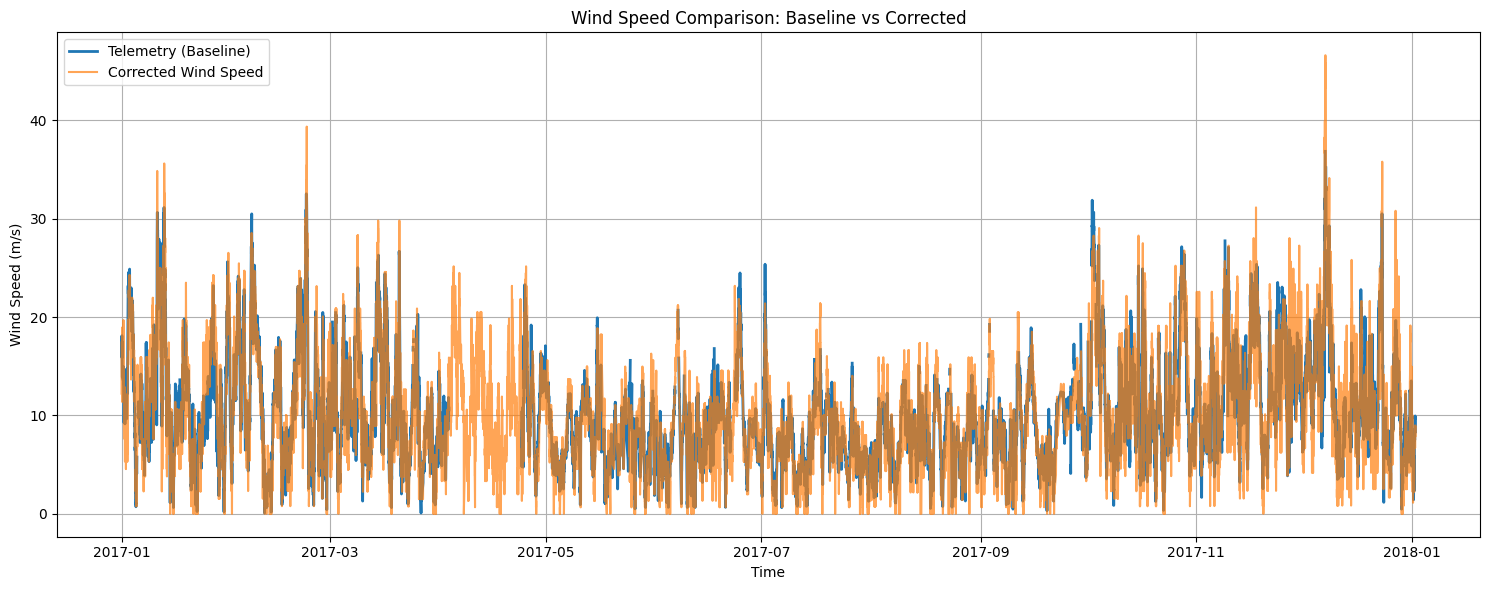

In [23]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Corrected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scale with Z-Scale

In [24]:
# I dont think its correct to scale with z-scale since it is not a normal distribution

# Energy Generated

$$
\begin{equation*} P(v)=\displaystyle \frac{1}{2}\rho Av^{3}C_{p}.\tag{1}\end{equation*}
$$

Where:

* $P$ = power output (in watts, W)
* $\rho$ = air density (in kg/m³), typically \~1.176 kg/m³ at at a height of 60 m above ground.
* $A$ = swept area of the rotor (in m²), $A = \pi r^2$
* $v$ = wind speed (in m/s)
* $C_p$ = power coefficient (efficiency), typically $\leq 0.59$ due to **Betz's limit**

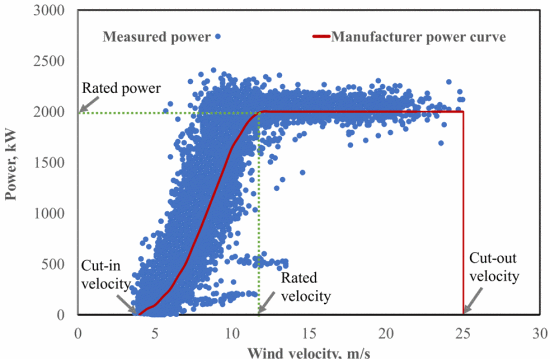

The output power is zero in Region 1 or in the range [0,$v_{ci}$ [. The cut-in speed, $v_{ci}$, is thus the minimal wind speed below which the output power is non-zero. The wind turbine must resist its own inertia to begin rotating the blades in that zone.

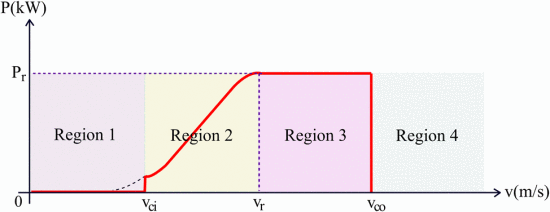

[Source](https://ieeexplore.ieee.org/document/10063743)

In [25]:
df_tt_wd.head()

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,Month_int,correction_factor,Wind_speed_monthly_scaled
0,2017-01-01 00:30:00,10.28,16.106667,893.266667,2017-01,1,1.69537,17.428404
1,2017-01-01 01:00:00,9.39,16.380000,897.633333,2017-01,1,1.69537,15.919524
2,2017-01-01 01:30:00,9.83,17.083333,899.966667,2017-01,1,1.69537,16.665487
3,2017-01-01 02:00:00,7.15,16.800000,900.000000,2017-01,1,1.69537,12.121896
4,2017-01-01 02:30:00,8.94,18.021739,899.956522,2017-01,1,1.69537,15.156608


### Deriving Rotor Radius

In [26]:
# Constants
rho = 1.225  # air density in kg/m³
cp = 0.35    # power coefficient
pi = np.pi

# Only use data where baseline power is below setpoint
valid = (df_tt_wd['Power_baseline'] < 880) & (df_tt_wd['Power_baseline'] > 20)

# Use the corrected wind speed and power baseline
P = df_tt_wd.loc[valid, 'Power_baseline'] * 1000  # convert kW to W
v = df_tt_wd.loc[valid, 'Wind_speed_baseline']

# Avoid division by zero or very small wind speeds
safe = v > 0
P = P[safe]
v = v[safe]

# Calculate rotor radius and diameter
r = np.sqrt((2 * P) / (rho * pi * v**3 * cp))

print(f"Mean rotor radius: {r.mean()} m")
print(f"Standard deviation of rotor radius: {r.std()} m")
print(f"Min rotor radius: {r.min()} m")
print(f"Max rotor radius: {r.max()} m")





Mean rotor radius: 25.87889655327397 m
Standard deviation of rotor radius: 3.6624578715335585 m
Min rotor radius: 1.0085586470582693 m
Max rotor radius: 40.83395682948988 m


## Naive Approach - calculate estimated power using scraped wind data

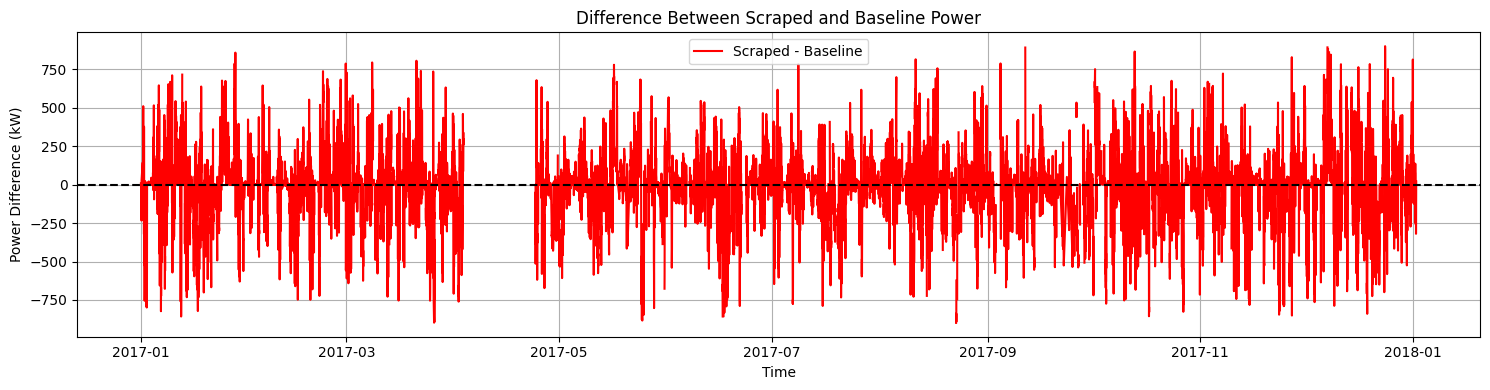

In [27]:
_r = r.mean()

def naive_power(v:float,rho:float=1.225, r:float = _r ,cp:float= 0.35) -> float:
    return 0.5 * rho * (np.pi * (r**2)) * (v**3) * cp / 1000
    
df_tt_wd['Naive_Power_scraped'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: naive_power(v, r = _r))

#add cap to 900
df_tt_wd['Naive_Power_scraped'] = df_tt_wd['Naive_Power_scraped'].clip(upper=900)

#visualize

df_tt_wd['Naive_Power_diff'] = df_tt_wd['Naive_Power_scraped'] - df_tt_wd['Power_baseline']

plt.figure(figsize=(15, 4))
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Naive_Power_diff'], color='red', label='Scraped - Baseline')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Difference (kW)')
plt.title('Difference Between Scraped and Baseline Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error,r2_score

# Only compare where both values are available (i.e., not NaN)
valid_mse = df_tt_wd[['Naive_Power_scraped', 'Power_baseline']].dropna()

mse_naive = mean_squared_error(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])
rmse_naive = np.sqrt(mse_naive)
r2_naive = r2_score(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])

print(f"Naive MSE: {mse_naive:.2f} kW²")
print(f"Naive RMSE: {rmse_naive:.2f} kW")
print(f"Naive R² Score: {r2_naive:.4f}")

Naive MSE: 49610.15 kW²
Naive RMSE: 222.73 kW
Naive R² Score: 0.5587


## Weibull Cumulative Distribution Power Output Model

$$
\begin{equation*} P(\nu)=P_r\left(1-e^{-\left(\frac{v-v_0}{c}\right)^3}\right),\tag{10}\end{equation*}
$$


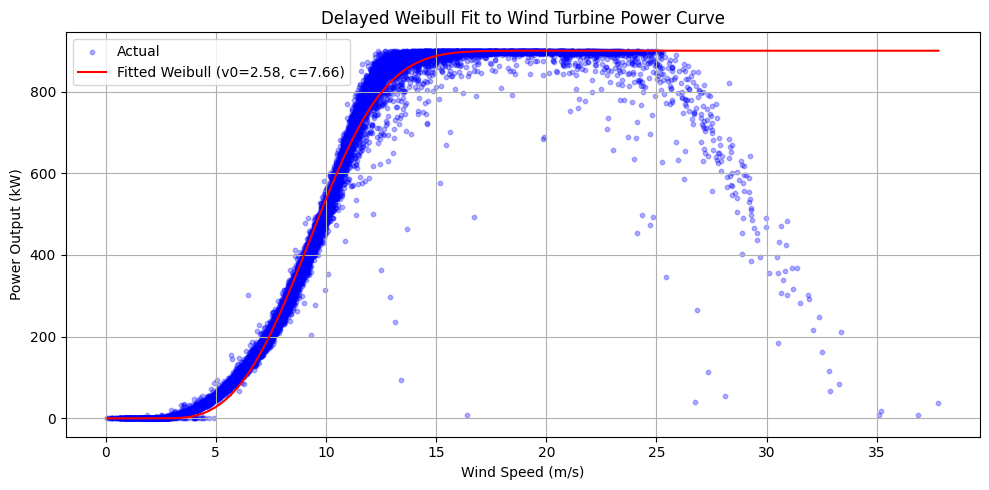

(np.float64(2.583001282770365), np.float64(7.664525041260357))

In [29]:
from scipy.optimize import curve_fit

def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])
wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

### Using Our Wind data

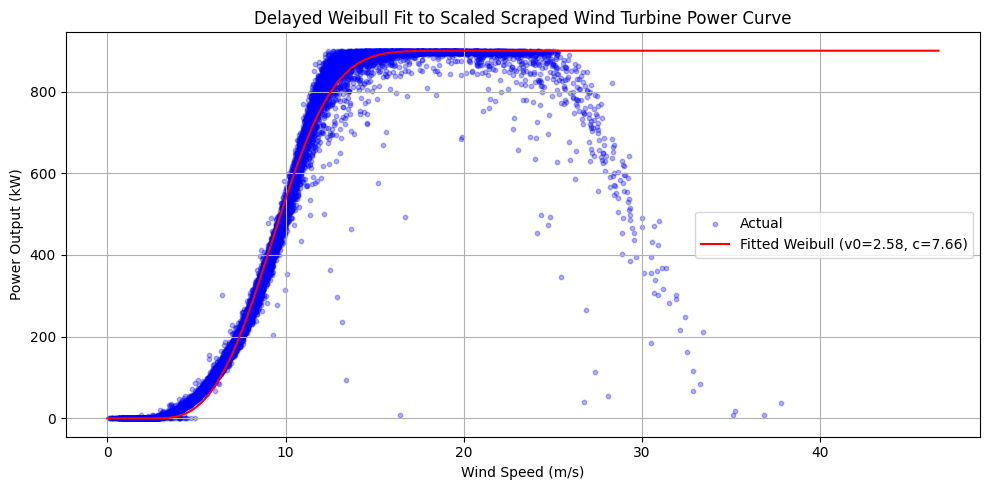

In [30]:
sorted_scaled_wind = np.sort(df_tt_wd['Wind_speed_monthly_scaled'].dropna())
# Predicted values using fitted parameters
predicted_sorted = delayed_weibull(sorted_scaled_wind, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(sorted_scaled_wind, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Scaled Scraped Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Calculate the Weibull power curve using the fitted parameters

df_tt_wd['Weibull_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: delayed_weibull(v, v0_fit, c_fit, pr=900))

Weilbull Mean Absolute Error (MAE): 147.3472394054607
Weilbull Root Mean Squared Error (RMSE): 222.25203119446147
Weilbull R² Score: 0.5606101800680148


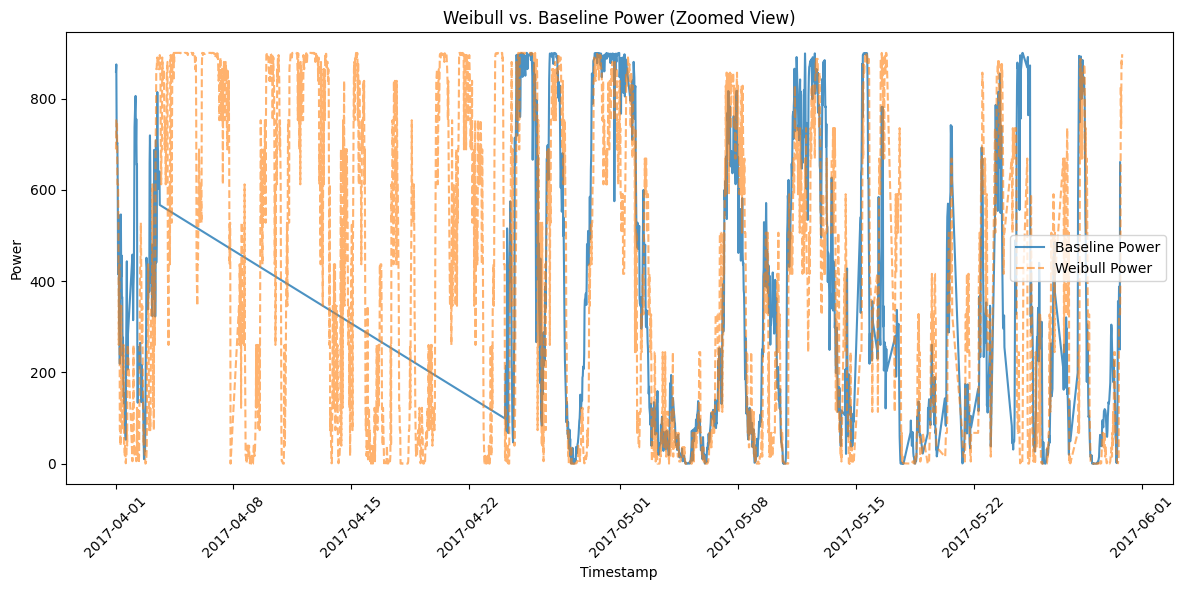

In [32]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
# Load your data (replace with actual path or DataFrame)
# df = pd.read_csv('your_data.csv')

# --- Statistical Comparison ---
valid_stats = df_tt_wd[['Weibull_Power', 'Power_baseline']].dropna()
mae_wb = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
rmse_wb = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
r2_wb = r2_score(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])

print("Weilbull Mean Absolute Error (MAE):", mae_wb)
print("Weilbull Root Mean Squared Error (RMSE):", rmse_wb)
print("Weilbull R² Score:", r2_wb)

# --- Plotting Comparison ---
df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-04-01') & (df_tt_wd['Timestamp'] <= '2017-05-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='Weibull_Power', data=df_zoom, label='Weibull Power', linestyle='--', alpha=0.6)
plt.title('Weibull vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


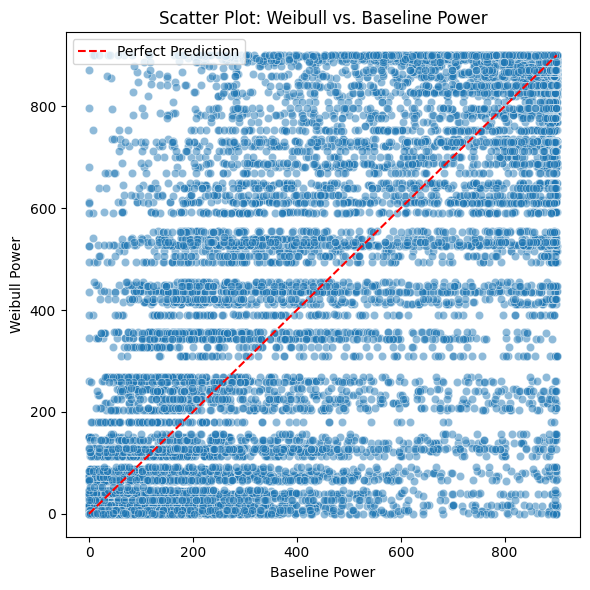

In [33]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Power_baseline', y='Weibull_Power', data=df_tt_wd, alpha=0.5)
plt.plot([df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         [df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         'r--', label='Perfect Prediction')
plt.title('Scatter Plot: Weibull vs. Baseline Power')
plt.xlabel('Baseline Power')
plt.ylabel('Weibull Power')
plt.legend()
plt.tight_layout()
plt.show()


## 3PL

$$
\begin{equation*} P(\nu)=P_{r}\displaystyle \frac{1}{1+e^{-\gamma(\nu-v_{0})^{3}}},\tag{12}\end{equation*}
$$

/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_93561/3595162123.py:14: RuntimeWarning: overflow encountered in exp
  return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))


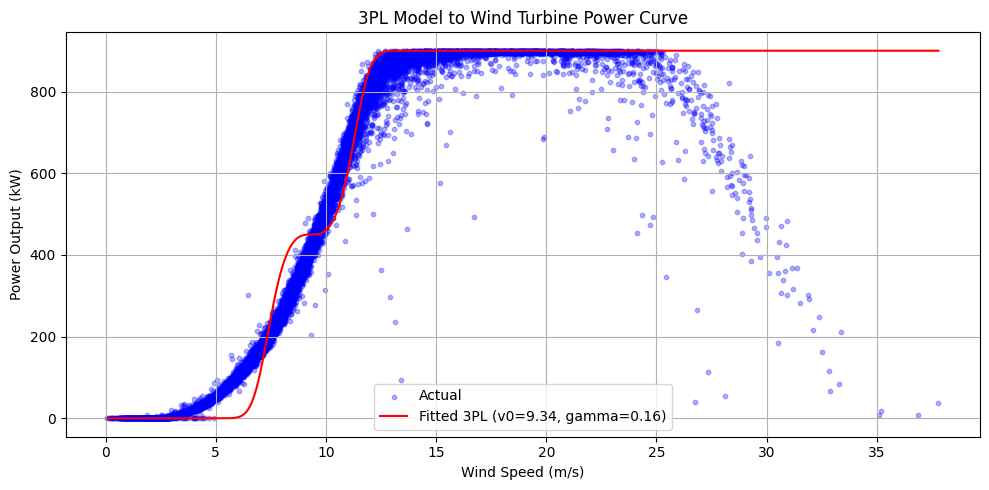

(np.float64(9.335692373869865), np.float64(7.664525041260357))

In [34]:
def three_pl(v, v0, gamma, pr):
    """
    Logistic model for wind speed distribution.
    
    Parameters:
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the logistic distribution in m/s.
    gamma (float): Shape parameter of the logistic distribution.
    pr (float): Power rating of the turbine in kW.
    
    Returns:
    float: Power output in kW.
    """
    return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])
wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and gamma
initial_guess = [1, 2]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, gamma: three_pl(v, v0, gamma, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, g_fit = popt
predicted_power = three_pl(wind, v0_fit, g_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = three_pl(v_sorted, v0_fit, g_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted 3PL (v0={v0_fit:.2f}, gamma={g_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('3PL Model to Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

3PL Mean Absolute Error (MAE): 159.44644411696268
3PL Root Mean Squared Error (RMSE): 236.74507916062308
3PL R² Score: 0.5014365524763966


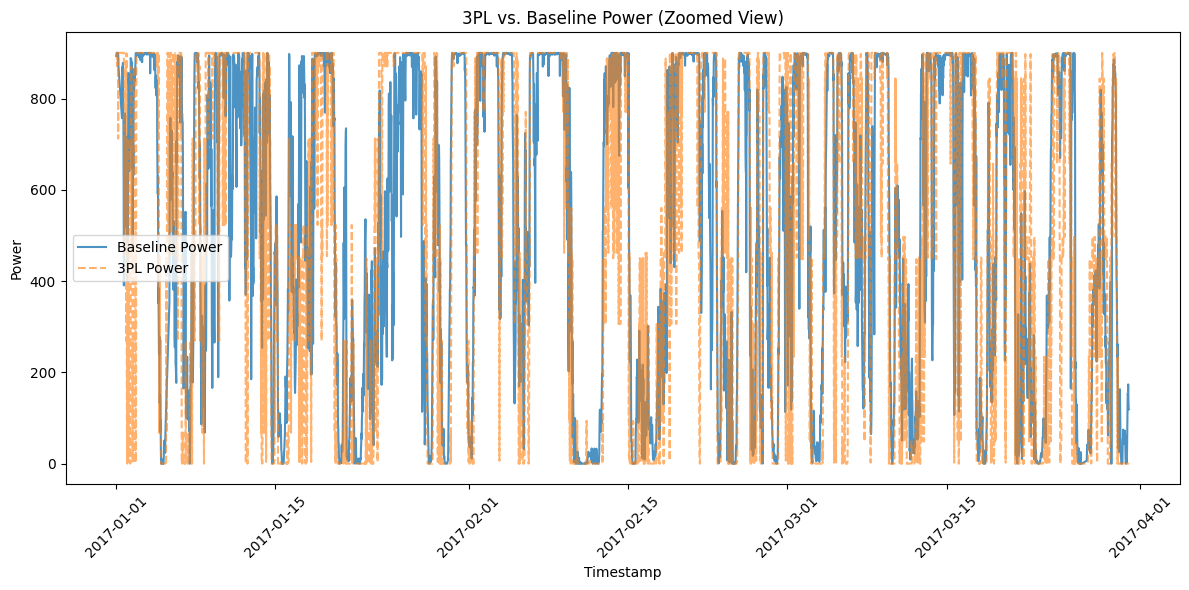

In [35]:
df_tt_wd['3PL_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: three_pl(v, v0_fit, g_fit, pr=900))

# --- Statistical Comparison ---
valid_stats = df_tt_wd[['3PL_Power', 'Power_baseline']].dropna()
mae_3pl = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
rmse_3pl = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
r2_3pl = r2_score(valid_stats['Power_baseline'], valid_stats['3PL_Power'])

print("3PL Mean Absolute Error (MAE):", mae_3pl)
print("3PL Root Mean Squared Error (RMSE):", rmse_3pl)
print("3PL R² Score:", r2_3pl)

# --- Plotting Comparison ---
df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-01-01') & (df_tt_wd['Timestamp'] <= '2017-03-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='3PL_Power', data=df_zoom, label='3PL Power', linestyle='--', alpha=0.6)
plt.title('3PL vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Compare Three Approaches

In [36]:
comparison_df = pd.DataFrame({
    "Model": ["Naive", "Weibull", "3PL"],
    "MAE": [np.nan,mae_wb, mae_3pl],
    "RMSE": [rmse_naive,rmse_wb, rmse_3pl],
    "R²": [r2_naive,r2_wb, r2_3pl]
})

comparison_df

,Model,MAE,RMSE,R²
0,Naive,NaN,222.733353,0.558705
1,Weibull,147.347239,222.252031,0.560610
2,3PL,159.446444,236.745079,0.501437


Weibull function appear to be the better for modelling the wind turbine power curve.

# Curtailment

## The Great Graph

In [37]:
df_rd.head()

,Timestamp,Demand_mean_kw,N_households
0,2017-01-01 00:00:00,0.220106,5428
1,2017-01-01 00:30:00,0.205945,5429
2,2017-01-01 01:00:00,0.189090,5429
3,2017-01-01 01:30:00,0.173118,5429
4,2017-01-01 02:00:00,0.159051,5429


In [38]:
# join rd with df_tt_wd

df_tt_wd_rd = pd.merge(
    df_rd[['Timestamp', 'Demand_mean_kw','N_households']],
    df_tt_wd[['Timestamp', 'Wind_speed_monthly_scaled', 'Power_baseline', 'Weibull_Power', '3PL_Power']],
    how='inner',
    on='Timestamp'
)

df_tt_wd_rd['Timestamp'] = pd.to_datetime(df_tt_wd_rd['Timestamp'])

df_tt_wd_rd.head()
    

,Timestamp,Demand_mean_kw,N_households,Wind_speed_monthly_scaled,Power_baseline,Weibull_Power,3PL_Power
0,2017-01-01 00:30:00,0.205945,5429,17.428404,893.266667,899.371249,900.000000
1,2017-01-01 01:00:00,0.189090,5429,15.919524,897.633333,895.362966,900.000000
2,2017-01-01 01:30:00,0.173118,5429,16.665487,899.966667,898.178475,900.000000
3,2017-01-01 02:00:00,0.159051,5429,12.121896,900.000000,769.065192,870.702911
4,2017-01-01 02:30:00,0.147656,5429,15.156608,899.956522,889.114144,900.000000


In [39]:
n_wind_turbines = 10
df_curtailment = pd.DataFrame({
    'Timestamp': df_tt_wd_rd['Timestamp'],
    'Generated_power': df_tt_wd_rd['Weibull_Power']*n_wind_turbines,
    'Demand_power': df_tt_wd_rd['Demand_mean_kw']*df_tt_wd_rd['N_households']
})
df_curtailment['Curtailment'] = df_curtailment['Generated_power'] - df_curtailment['Demand_power']
df_curtailment['Generated_power_smooth'] = df_curtailment['Generated_power'].rolling(window=6, center=True).mean()
df_curtailment['Demand_power_smooth'] = df_curtailment['Demand_power'].rolling(window=6, center=True).mean()
df_curtailment['Curtailment_smooth'] = df_curtailment['Curtailment'].rolling(window=6, center=True).mean()


print(f"Max Generated Power: {df_curtailment['Generated_power'].max()}")
print(f"Max Demand Power: {df_curtailment['Demand_power'].max()}")
print(f"Max Curtailment: {df_curtailment['Curtailment'].max()}")
print(f"Min Generated Power: {df_curtailment['Generated_power'].min()}")
print(f"Min Demand Power: {df_curtailment['Demand_power'].min()}")
print(f"Min Curtailment: {df_curtailment['Curtailment'].min()}")

Max Generated Power: 9000.0
Max Demand Power: 9688.176000000001
Max Curtailment: 8410.53
Min Generated Power: 0.0
Min Demand Power: 568.0880000000001
Min Curtailment: -9688.176000000001


In [42]:
df_curtailment_zoom = df_curtailment[(df_curtailment['Timestamp'] >= '2017-01-01') & (df_curtailment['Timestamp'] <= '2017-03-31')]

fig = go.Figure()

# Generated Power
fig.add_trace(go.Scatter(
    x=df_curtailment_zoom['Timestamp'],
    y=df_curtailment_zoom['Generated_power_smooth'],
    mode='lines',
    name='Generated Power (kW)',
    line=dict(color='green')
))

# Demand Power
fig.add_trace(go.Scatter(
    x=df_curtailment_zoom['Timestamp'],
    y=df_curtailment_zoom['Demand_power_smooth'],
    mode='lines',
    name='Demand Power (kW)',
    line=dict(color='blue')
))

# Curtailment
fig.add_trace(go.Scatter(
    x=df_curtailment_zoom['Timestamp'],
    y=df_curtailment_zoom['Curtailment_smooth'],
    mode='lines',
    name='Curtailment (kW)',
    line=dict(color='red', dash='dot')
))

fig.update_layout(
    title='Power Generation vs Demand and Curtailment',
    xaxis_title='Timestamp',
    yaxis_title='Power (kW)',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.write_html(FIGURES_PATH/"curtailment_plot.html")
# fig.show()